> **Problem overview**

This challenge serves as final project for the "How to win a data science competition" Coursera course. In this competition you will work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company. 

We are asking you to predict total sales for every product and store in the next month. By solving this competition you will be able to apply and enhance your data science skills.

In [1]:
# import data manipulation library
import numpy as np
import pandas as pd

# import data visualization library
import matplotlib.pyplot as plt
import seaborn as sns

# import sklearn data preprocessing
from sklearn.preprocessing import LabelEncoder

# import xgboost model class
import xgboost as xgb

# import sklearn model selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# import sklearn model evaluation regression metrics
from sklearn.metrics import mean_squared_error

In [2]:
# pandas options
pd.options.display.max_rows = 10

> **Acquiring training and testing data**

We start by acquiring the training and testing datasets into Pandas DataFrames.

In [3]:
# acquiring training and testing data
df_train = pd.read_csv('../input/sales_train.csv')
df_test = pd.read_csv('../input/test.csv')

In [4]:
# acquiring supplemental information
df_items = pd.read_csv('../input/items.csv')
df_categories = pd.read_csv('../input/item_categories.csv')
df_shops = pd.read_csv('../input/shops.csv')

In [5]:
# visualize head of the training data
df_train.head(n=5)

date  date_block_num      ...       item_price  item_cnt_day
0  02.01.2013               0      ...           999.00           1.0
1  03.01.2013               0      ...           899.00           1.0
2  05.01.2013               0      ...           899.00          -1.0
3  06.01.2013               0      ...          1709.05           1.0
4  15.01.2013               0      ...          1099.00           1.0

[5 rows x 6 columns]

In [6]:
# visualize tail of the testing data
df_test.tail(n=5)

ID  shop_id  item_id
214195  214195       45    18454
214196  214196       45    16188
214197  214197       45    15757
214198  214198       45    19648
214199  214199       45      969

In [7]:
# visualize head of the supplemental information about the items/products
df_items.head(n=5)

item_name        ...         item_category_id
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        ...                       40
1  !ABBYY FineReader 12 Professional Edition Full...        ...                       76
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        ...                       40
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        ...                       40
4        ***КОРОБКА (СТЕКЛО)                       D        ...                       40

[5 rows x 3 columns]

In [8]:
# visualize head of the supplemental information about the items categories
df_categories.head(n=5)

item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4

In [9]:
# visualize head of the supplemental information about the shops
df_shops.head(n=5)

shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
1   !Якутск ТЦ "Центральный" фран        1
2                Адыгея ТЦ "Мега"        2
3  Балашиха ТРК "Октябрь-Киномир"        3
4        Волжский ТЦ "Волга Молл"        4

In [10]:
# combine training and testing dataframe
df_train['datatype'], df_test['datatype'] = 'training', 'testing'
df_train.insert(0, 'ID', np.nan)
df_test.insert(1, 'date', '01.11.2015')
df_test.insert(2, 'date_block_num', 34)
df_test.insert(df_test.shape[1] - 1, 'item_price', np.nan)
df_test.insert(df_test.shape[1] - 1, 'item_cnt_day', np.nan)
df_data = pd.concat([df_train, df_test], ignore_index=False)

> **Feature exploration, engineering and cleansing**

Here we generate descriptive statistics that summarize the central tendency, dispersion and shape of a dataset’s distribution together with exploring some data.

In [11]:
# countplot function plot - categorical variable (x-axis) vs. categorical variable (y-axis)
def countplot(x = None, y = None, data = None, ncols = 5, nrows = 3):
    fig, axes = plt.subplots(figsize=(4*ncols , 3*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    for i, v in enumerate(x): sns.countplot(x=v, hue=y, data=data, ax=axes[i])

In [12]:
# boxplot function plot - categorical variable (x-axis) vs. numerical variable (y-axis)
def boxplot(cat = None, num = None, data = None, ncols = 5, nrows = 3):
    fig, axes = plt.subplots(figsize=(4*ncols , 3*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    if type(cat) == list:
        for i, v in enumerate(cat): sns.boxplot(x=v, y=num, data=data, ax=axes[i])
    else:
        for i, v in enumerate(num): sns.boxplot(x=cat, y=v, data=data, ax=axes[i])

In [13]:
# boxplot function sorted plot - categorical variable (x-axis) vs. numerical variable (y-axis)
def boxplotsort(cat = None, num = None, data = None, ncols = 5, nrows = 3, orderby='median'):
    fig, axes = plt.subplots(figsize=(4*ncols , 3*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    if type(cat) == list:
        for i, v in enumerate(cat): sns.boxplot(x=v, y=num, data=data, ax=axes[i], order=data.groupby([v], as_index=True).agg({num: orderby}).sort_values(num).index)
    else:
        for i, v in enumerate(num): sns.boxplot(x=cat, y=v, data=data, ax=axes[i], order=data.groupby([cat], as_index=True).agg({v: orderby}).sort_values(v).index)

In [14]:
# swarmplot function plot - categorical variable (x-axis) vs. numerical variable (y-axis)
def swarmplot(cat = None, num = None, data = None, ncols = 5, nrows = 3):
    fig, axes = plt.subplots(figsize=(4*ncols , 3*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    if type(cat) == list:
        for i, v in enumerate(cat): sns.swarmplot(x=v, y=num, data=data, ax=axes[i])
    else:
        for i, v in enumerate(num): sns.swarmplot(x=cat, y=v, data=data, ax=axes[i])

In [15]:
# violinplot function plot - categorical variable (x-axis) vs. numerical variable (y-axis)
def violinplot(cat = None, num = None, data = None, ncols = 5, nrows = 3):
    fig, axes = plt.subplots(figsize=(4*ncols , 3*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    if type(cat) == list:
        for i, v in enumerate(cat): sns.violinplot(x=v, y=num, data=data, ax=axes[i])
    else:
        for i, v in enumerate(num): sns.violinplot(x=cat, y=v, data=data, ax=axes[i])

In [16]:
# violinplot function sorted plot - categorical variable (x-axis) vs. numerical variable (y-axis)
def violinplotsort(cat = None, num = None, data = None, ncols = 5, nrows = 3, orderby='median'):
    fig, axes = plt.subplots(figsize=(4*ncols , 3*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    if type(cat) == list:
        for i, v in enumerate(cat): sns.violinplot(x=v, y=num, data=data, ax=axes[i], order=data.groupby([v], as_index=True).agg({num: orderby}).sort_values(num).index)
    else:
        for i, v in enumerate(num): sns.violinplot(x=cat, y=v, data=data, ax=axes[i], order=data.groupby([cat], as_index=True).agg({v: orderby}).sort_values(v).index)

In [17]:
# scatterplot function plot - numerical variable (x-axis) vs. numerical variable (y-axis)
def scatterplot(x = None, y = None, data = None, ncols = 5, nrows = 3):
    fig, axes = plt.subplots(figsize=(4*ncols , 3*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    for i, xi in enumerate(x): sns.scatterplot(x=xi, y=y, data=data, ax=axes[i])

In [18]:
# describe training and testing data
df_data.describe(include='all')

ID        date    ...     item_cnt_day  datatype
count   214200.00     3150049    ...     2.935849e+06   3150049
unique        NaN        1035    ...              NaN         2
top           NaN  01.11.2015    ...              NaN  training
freq          NaN      214200    ...              NaN   2935849
mean    107099.50         NaN    ...     1.242641e+00       NaN
...           ...         ...    ...              ...       ...
min          0.00         NaN    ...    -2.200000e+01       NaN
25%      53549.75         NaN    ...     1.000000e+00       NaN
50%     107099.50         NaN    ...     1.000000e+00       NaN
75%     160649.25         NaN    ...     1.000000e+00       NaN
max     214199.00         NaN    ...     2.169000e+03       NaN

[11 rows x 8 columns]

In [19]:
# feature extraction: fix the duplicated shop id
df_data.loc[df_data['shop_id'] == 0, 'shop_id'] = 57
df_data.loc[df_data['shop_id'] == 1, 'shop_id'] = 58
df_data.loc[df_data['shop_id'] == 11, 'shop_id'] = 10

In [20]:
# feature extraction: merge with supplemental information about the items/products
df_data = pd.merge(df_data, df_items, how='left', left_on='item_id', right_on='item_id')

In [21]:
# feature extraction: merge with supplemental information about the items categories
df_data = pd.merge(df_data, df_categories, how='left', left_on='item_category_id', right_on='item_category_id')

In [22]:
# feature extraction: merge with supplemental information about the shops
df_data = pd.merge(df_data, df_shops, how='left', left_on='shop_id', right_on='shop_id')

In [23]:
# convert dtypes numeric to object
col_convert = ['date_block_num', 'shop_id', 'item_id', 'item_category_id']
df_data[col_convert] = df_data[col_convert].astype('object')

In [24]:
# list all features type number
col_number = df_data.select_dtypes(include=['number']).columns.tolist()
print('features type number:\n items %s\n length %d' %(col_number, len(col_number)))

# list all features type object
col_object = df_data.select_dtypes(include=['object']).columns.tolist()
print('features type object:\n items %s\n length %d' %(col_object, len(col_object)))

features type number:
 items ['ID', 'item_price', 'item_cnt_day']
 length 3
features type object:
 items ['date', 'date_block_num', 'shop_id', 'item_id', 'datatype', 'item_name', 'item_category_id', 'item_category_name', 'shop_name']
 length 9


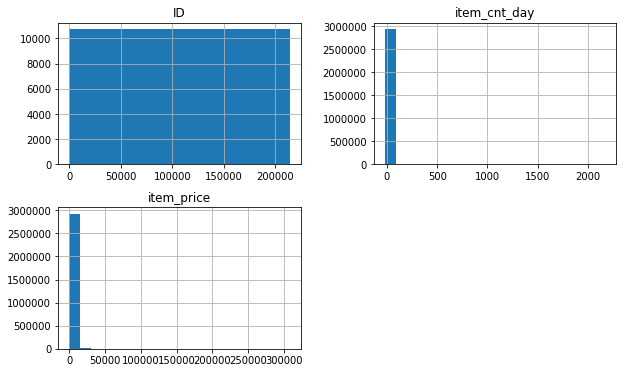

In [25]:
# feature exploration: histogram of all numeric features
_ = df_data.hist(bins=20, figsize=(10, 6))

In [26]:
# feature extraction: set maximum and minimum limit for item price
df_data = df_data[((df_data['item_price'] >= 0) & (df_data['item_price'] <= 100000)) | (df_data['item_price'].isna())]
df_data['item_price'] = np.log1p(df_data['item_price'])

In [27]:
# feature extraction: set maximum and minimum limit for number of products sold
df_data = df_data[((df_data['item_cnt_day'] >= 0) & (df_data['item_cnt_day'] <= 1000)) | (df_data['item_cnt_day'].isna())]

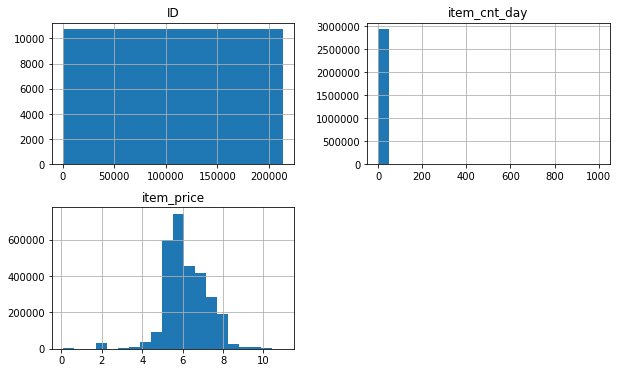

In [28]:
# feature exploration: histogram of all numeric features
_ = df_data.hist(bins=20, figsize=(10, 6))

In [29]:
# feature exploration: item id
df_data['item_id'].value_counts()

20949    31379
5822      9446
17717     9109
2808      7512
4181      6892
         ...  
7126         1
7080         1
7079         1
7063         1
0            1
Name: item_id, Length: 22166, dtype: int64

In [30]:
# feature exploration: category id
df_data['item_category_id'].value_counts()

40    596278
55    367351
30    356499
19    213251
37    205834
       ...  
52         3
50         2
1          2
10         1
51         1
Name: item_category_id, Length: 84, dtype: int64

In [31]:
# feature exploration: shop id
df_data['shop_id'].value_counts()

31    240285
25    190888
28    147118
54    143124
57    132071
       ...  
33      5005
40      4244
9       3743
8       3406
20      1791
Name: shop_id, Length: 57, dtype: int64

In [32]:
# feature exploration: item id 20949
df_items.loc[df_items['item_id'] == 20949, 'item_category_id']

20949    71
Name: item_category_id, dtype: int64

In [33]:
# feature exploration: category id 71
df_items.loc[df_items['item_category_id'] == 71, 'item_id']

7149      7149
13597    13597
13598    13598
20949    20949
21788    21788
21789    21789
Name: item_id, dtype: int64

In [34]:
# feature exploration: shop id 31
df_data.loc[df_data['shop_id'] == 31, 'item_category_id'].value_counts()

40    62930
55    30848
30    22077
37    15333
19    12011
      ...  
36        2
18        1
74        1
27        1
0         1
Name: item_category_id, Length: 74, dtype: int64

In [35]:
# feature exploration: category id 40
df_data.loc[df_data['item_category_id'] == 40, 'shop_id'].value_counts()

31    62930
57    41222
25    38940
54    35225
28    31004
      ...  
36      796
8       788
55      770
40       69
9         5
Name: shop_id, Length: 56, dtype: int64

The exploratory data analysis resulting in,

* **Item and category:** Some items have only few records with similar category id.

In [36]:
# feature extraction: combination of keyword date
df_data['date'] = pd.to_datetime(df_data['date'], format='%d.%m.%Y')
df_data['year'] = df_data['date'].dt.year - 2013
df_data['quarter'] = df_data['date'].dt.quarter
df_data['month'] = df_data['date'].dt.month
df_data['weekofyear'] = df_data['date'].dt.weekofyear
df_data['dayofweek'] = df_data['date'].dt.dayofweek

In [37]:
# feature extraction: city
df_data.loc[df_data['shop_name'] == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
df_data['city'] = df_data['shop_name'].str.split(' ').apply(lambda x: x[0])
df_data.loc[df_data['city'] == '!Якутск', 'city'] = 'Якутск'
df_data['city'].value_counts()

Москва       1030398
Якутск        214117
Воронеж       153985
СПб           153173
Химки         143124
              ...   
Балашиха       30513
Жуковский      26996
Томск          26623
Мытищи          5005
Выездная        3743
Name: city, Length: 31, dtype: int64

In [38]:
# feature extraction: city_code
df_data['city_code'] = LabelEncoder().fit_transform(df_data['city'])

In [39]:
# feature extraction: type
df_data['type'] = df_data['item_category_name'].str.split('-').apply(lambda x: x[0].strip())
df_data['type'].value_counts()

Кино                       884638
Игры                       546085
Игры PC                    525231
Музыка                     444946
Подарки                    411872
                            ...  
Билеты (Цифра)               1871
Чистые носители (шпиль)       794
Игры Android                  175
Игры MAC                       50
PC                             45
Name: type, Length: 20, dtype: int64

In [40]:
# feature extraction: type_code
df_data['type_code'] = LabelEncoder().fit_transform(df_data['type'])

In [41]:
# feature extraction: subtype
df_data['subtype'] = df_data['item_category_name'].str.split('-').apply(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
df_data['subtype'].value_counts()

DVD                           596278
CD локального производства    367351
Стандартные издания           356499
Blu                           253531
PS3                           238142
                               ...  
Компьютерная литература            6
Путеводители                       3
Художественная литература          3
Открытки                           2
Познавательная литература          1
Name: subtype, Length: 65, dtype: int64

In [42]:
# feature extraction: subtype_code
df_data['subtype_code'] = LabelEncoder().fit_transform(df_data['subtype'])

In [43]:
# feature extraction: block dataframe
df_block = df_data.groupby(['date_block_num', 'shop_id', 'item_id', 'item_category_id'], as_index=False).agg({
    'item_price': 'mean', 'item_cnt_day': sum,
    'year': 'first', 'quarter': 'first', 'month': 'first',
    'city_code': 'first', 'type_code': 'first', 'subtype_code': 'first'
}).rename(columns={'item_cnt_day': 'item_cnt_month'})

In [44]:
# describe block dataframe for month 0 - 33
df_block[df_block['date_block_num'] != 34].describe(include='all')

date_block_num       shop_id      ...          type_code  subtype_code
count    1.608225e+06  1.608225e+06      ...       1.608225e+06  1.608225e+06
mean     1.466503e+01  3.309496e+01      ...       1.028051e+01  1.793404e+01
std      9.542386e+00  1.646634e+01      ...       3.357272e+00  1.964855e+01
min      0.000000e+00  2.000000e+00      ...       0.000000e+00  0.000000e+00
25%      6.000000e+00  2.100000e+01      ...       8.000000e+00  2.000000e+00
50%      1.400000e+01  3.100000e+01      ...       1.100000e+01  1.000000e+01
75%      2.300000e+01  4.800000e+01      ...       1.300000e+01  3.200000e+01
max      3.300000e+01  5.900000e+01      ...       1.900000e+01  6.400000e+01

[8 rows x 12 columns]

In [45]:
# describe block dataframe for month 34
df_block[df_block['date_block_num'] == 34].describe(include='all')

date_block_num        shop_id      ...           type_code  subtype_code
count        214200.0  214200.000000      ...       214200.000000  214200.00000
mean             34.0      31.642857      ...           11.042549      22.78451
std               0.0      17.561933      ...            3.196935      21.17448
min              34.0       2.000000      ...            0.000000       0.00000
25%              34.0      16.000000      ...           11.000000       4.00000
50%              34.0      34.500000      ...           12.000000      16.00000
75%              34.0      47.000000      ...           13.000000      41.00000
max              34.0      59.000000      ...           19.000000      64.00000

[8 rows x 12 columns]

In [46]:
# feature extraction: item price fillna by shop id and category id from previous month
npshopids = df_block['shop_id'].unique()
npcategoryids = df_block['item_category_id'].unique()
for npshopid in npshopids:
    for npcategoryid in npcategoryids:
        df_condition33 = (df_block['date_block_num'] == 33) & (df_block['shop_id'] == npshopid) & (df_block['item_category_id'] == npcategoryid)
        df_condition34 = (df_block['date_block_num'] == 34) & (df_block['shop_id'] == npshopid) & (df_block['item_category_id'] == npcategoryid)
        df_block.loc[df_condition34, 'item_price'] = df_block.loc[df_condition34, 'item_price'].fillna(df_block.loc[df_condition33, 'item_price'].mean())

In [47]:
# feature extraction: item price fillna by category id from previous month
npcategoryids = df_block['item_category_id'].unique()
for npcategoryid in npcategoryids:
    df_condition33 = (df_block['date_block_num'] == 33) & (df_block['item_category_id'] == npcategoryid)
    df_condition34 = (df_block['date_block_num'] == 34) & (df_block['item_category_id'] == npcategoryid)
    df_block.loc[df_condition34, 'item_price'] = df_block.loc[df_condition34, 'item_price'].fillna(df_block.loc[df_condition33, 'item_price'].mean())

In [48]:
# feature extraction: item price fillna by category id
npcategoryids = df_block['item_category_id'].unique()
for npcategoryid in npcategoryids:
    df_condition = df_block['item_category_id'] == npcategoryid
    df_block.loc[df_condition, 'item_price'] = df_block.loc[df_condition, 'item_price'].fillna(df_block.loc[df_condition, 'item_price'].mean())

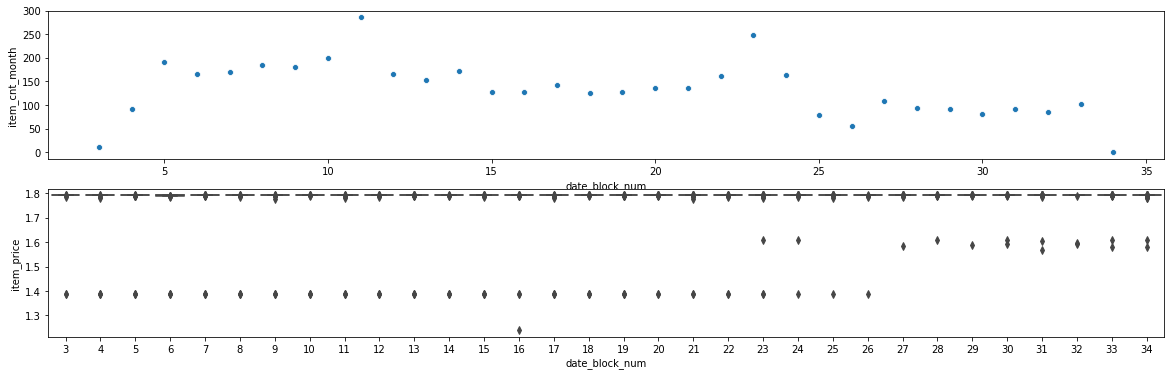

In [49]:
# feature exploration: item price and number of products sold by item id 20949
fig, axes = plt.subplots(figsize=(20 , 6), ncols=1, nrows=2)
axes = axes.flatten()
sns.scatterplot(x='date_block_num', y='item_cnt_month', data=df_block[df_block['item_id'] == 20949].groupby(['date_block_num'], as_index=False).agg({'item_cnt_month': 'mean'}), ax=axes[0])
sns.boxplot(x='date_block_num', y='item_price', data=df_block[df_block['item_id'] == 20949], ax=axes[1])

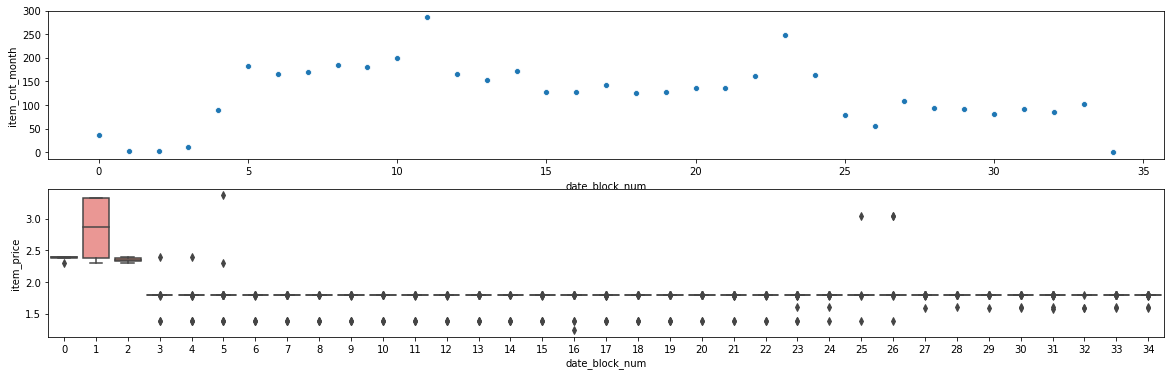

In [50]:
# feature exploration: item price and number of products sold by category id 71
fig, axes = plt.subplots(figsize=(20 , 6), ncols=1, nrows=2)
axes = axes.flatten()
sns.scatterplot(x='date_block_num', y='item_cnt_month', data=df_block[df_block['item_category_id'] == 71].groupby(['date_block_num'], as_index=False).agg({'item_cnt_month': 'mean'}), ax=axes[0])
sns.boxplot(x='date_block_num', y='item_price', data=df_block[df_block['item_category_id'] == 71], ax=axes[1])

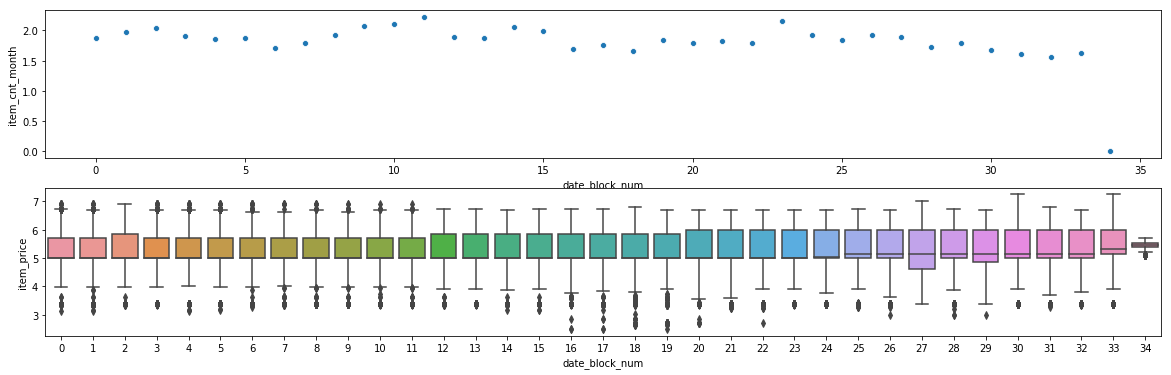

In [51]:
# feature exploration: item price and number of products sold by category id 40
fig, axes = plt.subplots(figsize=(20 , 6), ncols=1, nrows=2)
axes = axes.flatten()
sns.scatterplot(x='date_block_num', y='item_cnt_month', data=df_block[df_block['item_category_id'] == 40].groupby(['date_block_num'], as_index=False).agg({'item_cnt_month': 'mean'}), ax=axes[0])
sns.boxplot(x='date_block_num', y='item_price', data=df_block[df_block['item_category_id'] == 40], ax=axes[1])

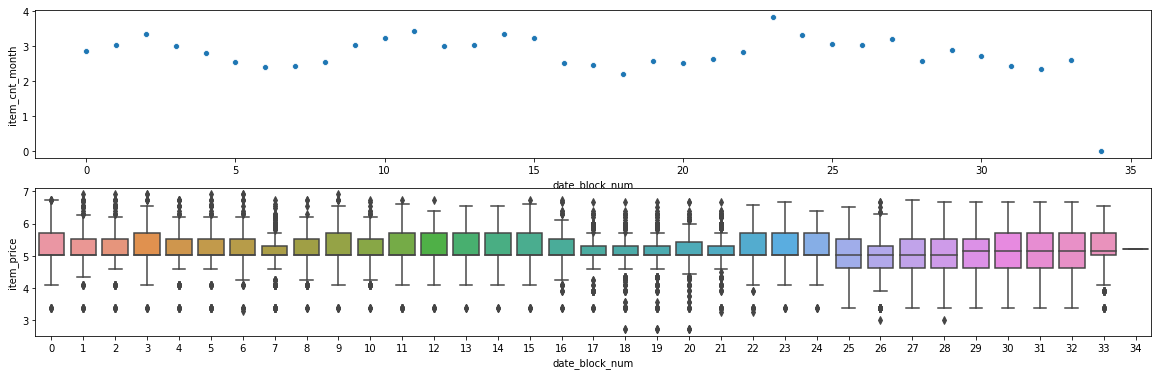

In [52]:
# feature exploration: item price and number of products sold by category id 40 and shop id 31
fig, axes = plt.subplots(figsize=(20 , 6), ncols=1, nrows=2)
axes = axes.flatten()
sns.scatterplot(x='date_block_num', y='item_cnt_month', data=df_block[(df_block['item_category_id'] == 40) & (df_block['shop_id'] == 31)].groupby(['date_block_num'], as_index=False).agg({'item_cnt_month': 'mean'}), ax=axes[0])
sns.boxplot(x='date_block_num', y='item_price', data=df_block[(df_block['item_category_id'] == 40) & (df_block['shop_id'] == 31)], ax=axes[1])

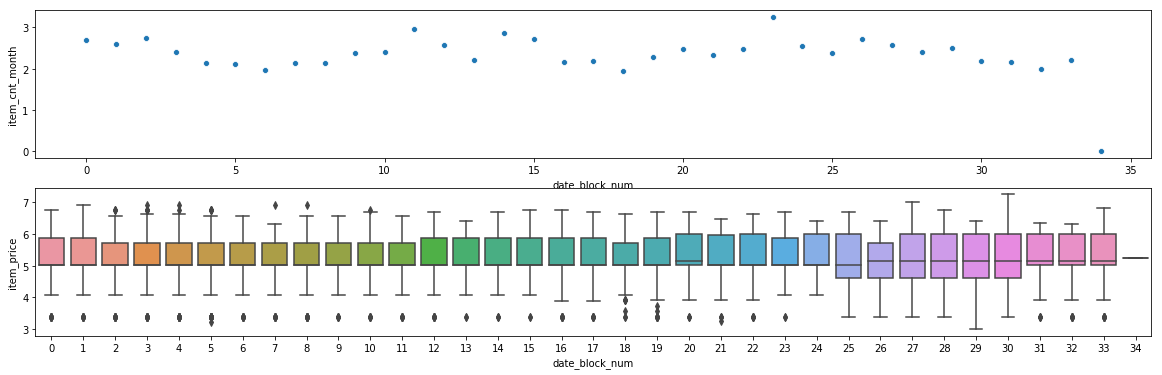

In [53]:
# feature exploration: item price and number of products sold by category id 40 and shop id 25
fig, axes = plt.subplots(figsize=(20 , 6), ncols=1, nrows=2)
axes = axes.flatten()
sns.scatterplot(x='date_block_num', y='item_cnt_month', data=df_block[(df_block['item_category_id'] == 40) & (df_block['shop_id'] == 25)].groupby(['date_block_num'], as_index=False).agg({'item_cnt_month': 'mean'}), ax=axes[0])
sns.boxplot(x='date_block_num', y='item_price', data=df_block[(df_block['item_category_id'] == 40) & (df_block['shop_id'] == 25)], ax=axes[1])

The exploratory data analysis resulting in,

* **Date, shop, item price and number of products sold:** Each items and categories have their own trends with date.

In [54]:
# feature extraction: shifted features for item price
for i in [1, 2, 3]:
    shifted = df_block[['date_block_num', 'shop_id', 'item_id', 'item_price']].copy(deep=True)
    shifted.columns = ['date_block_num', 'shop_id','item_id', 'item_price_shift' + str(i)]
    shifted['date_block_num'] = shifted['date_block_num'] + i
    df_block = pd.merge(df_block, shifted, how='left', on=['date_block_num', 'shop_id', 'item_id'])

In [55]:
# feature extraction: statistic features for item price by item, category and shop
df_block['item_price_by_item_mean'] = df_block.groupby(['item_id'])['item_price'].transform('mean')
df_block['item_price_by_category_mean'] = df_block.groupby(['item_category_id'])['item_price'].transform('mean')
df_block['item_price_by_shop_mean'] = df_block.groupby(['shop_id'])['item_price'].transform('mean')
df_block['item_price_by_category_shop_mean'] = df_block.groupby(['item_category_id', 'shop_id'])['item_price'].transform('mean')

In [56]:
# feature extraction: statistic features for item price by item, category, shop and date block
df_block['item_price_by_item_date_mean'] = df_block.groupby(['date_block_num', 'item_id'])['item_price'].transform('mean')
df_block['item_price_by_category_date_mean'] = df_block.groupby(['date_block_num', 'item_category_id'])['item_price'].transform('mean')
df_block['item_price_by_shop_date_mean'] = df_block.groupby(['date_block_num', 'shop_id'])['item_price'].transform('mean')
df_block['item_price_by_category_shop_date_mean'] = df_block.groupby(['date_block_num', 'item_category_id', 'shop_id'])['item_price'].transform('mean')

In [57]:
# feature extraction: statistic features for item price by city, type and subtype
df_block['item_price_by_city_mean'] = df_block.groupby(['city_code'])['item_price'].transform('mean')
df_block['item_price_by_type_mean'] = df_block.groupby(['type_code'])['item_price'].transform('mean')
df_block['item_price_by_subtype_mean'] = df_block.groupby(['subtype_code'])['item_price'].transform('mean')

In [58]:
# feature extraction: statistic features for item price by city, type, subtype and date block
df_block['item_price_by_city_date_mean'] = df_block.groupby(['date_block_num', 'city_code'])['item_price'].transform('mean')
df_block['item_price_by_type_date_mean'] = df_block.groupby(['date_block_num', 'type_code'])['item_price'].transform('mean')
df_block['item_price_by_subtype_date_mean'] = df_block.groupby(['date_block_num', 'subtype_code'])['item_price'].transform('mean')
df_block['item_price_by_city_type_date_mean'] = df_block.groupby(['date_block_num', 'city_code', 'type_code'])['item_price'].transform('mean')
df_block['item_price_by_city_subtype_date_mean'] = df_block.groupby(['date_block_num', 'city_code', 'subtype_code'])['item_price'].transform('mean')

In [59]:
# feature extraction: statistic shifted features for item price by item, category, shop and date block
for i in [1, 2, 3]:
    df_block['item_price_by_item_date_mean_shift' + str(i)] = df_block.groupby(['date_block_num', 'item_id'])['item_price_shift' + str(i)].transform('mean')
    df_block['item_price_by_category_date_mean_shift' + str(i)] = df_block.groupby(['date_block_num', 'item_category_id'])['item_price_shift' + str(i)].transform('mean')
    df_block['item_price_by_shop_date_mean_shift' + str(i)] = df_block.groupby(['date_block_num', 'shop_id'])['item_price_shift' + str(i)].transform('mean')
    df_block['item_price_by_category_shop_date_mean_shift' + str(i)] = df_block.groupby(['date_block_num', 'item_category_id', 'shop_id'])['item_price_shift' + str(i)].transform('mean')

In [60]:
# feature extraction: statistic shifted features for item price by city, type, subtype and date block
for i in [1, 2, 3]:
    df_block['item_price_by_city_date_mean_shift' + str(i)] = df_block.groupby(['date_block_num', 'city_code'])['item_price_shift' + str(i)].transform('mean')
    df_block['item_price_by_type_date_mean_shift' + str(i)] = df_block.groupby(['date_block_num', 'type_code'])['item_price_shift' + str(i)].transform('mean')
    df_block['item_price_by_subtype_date_mean_shift' + str(i)] = df_block.groupby(['date_block_num', 'subtype_code'])['item_price_shift' + str(i)].transform('mean')
    df_block['item_price_by_city_type_date_mean_shift' + str(i)] = df_block.groupby(['date_block_num', 'city_code', 'type_code'])['item_price_shift' + str(i)].transform('mean')
    df_block['item_price_by_city_subtype_date_mean_shift' + str(i)] = df_block.groupby(['date_block_num', 'city_code', 'subtype_code'])['item_price_shift' + str(i)].transform('mean')

In [61]:
# feature extraction: statistic shifted features for delta item price by item, category, shop and date block
for i in [1, 2, 3]:
    df_block['delta_item_price_by_item_date_mean_shift' + str(i)] = df_block['item_price_by_item_date_mean_shift' + str(i)] - df_block['item_price_by_item_date_mean']
    df_block['delta_item_price_by_category_date_mean_shift' + str(i)] = df_block['item_price_by_category_date_mean_shift' + str(i)] - df_block['item_price_by_category_date_mean']
    df_block['delta_item_price_by_shop_date_mean_shift' + str(i)] = df_block['item_price_by_shop_date_mean_shift' + str(i)] - df_block['item_price_by_shop_date_mean']
    df_block['delta_item_price_by_category_shop_date_mean_shift' + str(i)] = df_block['item_price_by_category_shop_date_mean_shift' + str(i)] - df_block['item_price_by_category_shop_date_mean']

In [62]:
# feature extraction: statistic shifted features for delta item price by city, type, subtype and date block
for i in [1, 2, 3]:
    df_block['delta_item_price_by_city_date_mean_shift' + str(i)] = df_block['item_price_by_city_date_mean_shift' + str(i)] - df_block['item_price_by_city_date_mean']
    df_block['delta_item_price_by_type_date_mean_shift' + str(i)] = df_block['item_price_by_type_date_mean_shift' + str(i)] - df_block['item_price_by_type_date_mean']
    df_block['delta_item_price_by_subtype_date_mean_shift' + str(i)] = df_block['item_price_by_subtype_date_mean_shift' + str(i)] - df_block['item_price_by_subtype_date_mean']
    df_block['delta_item_price_by_city_type_date_mean_shift' + str(i)] = df_block['item_price_by_city_type_date_mean_shift' + str(i)] - df_block['item_price_by_city_type_date_mean']
    df_block['delta_item_price_by_city_subtype_date_mean_shift' + str(i)] = df_block['item_price_by_city_subtype_date_mean_shift' + str(i)] - df_block['item_price_by_city_subtype_date_mean']

In [63]:
# feature extraction: set maximum and minimum limit for number of products sold
df_block['item_cnt_month'] = df_block['item_cnt_month'].clip(0 ,20)

In [64]:
# feature extraction: shifted features for number of products sold
for i in [1, 2, 3, 6, 12]:
    shifted = df_block[['date_block_num', 'shop_id', 'item_id', 'item_cnt_month']].copy(deep=True)
    shifted.columns = ['date_block_num', 'shop_id','item_id', 'item_cnt_month_shift' + str(i)]
    shifted['date_block_num'] = shifted['date_block_num'] + i
    df_block = pd.merge(df_block, shifted, how='left', on=['date_block_num', 'shop_id', 'item_id'])

In [65]:
# feature extraction: statistic features for number of products sold by item, category and shop
df_block['item_cnt_month_by_item_mean'] = df_block.groupby(['item_id'])['item_cnt_month'].transform('mean')
df_block['item_cnt_month_by_category_mean'] = df_block.groupby(['item_category_id'])['item_cnt_month'].transform('mean')
df_block['item_cnt_month_by_shop_mean'] = df_block.groupby(['shop_id'])['item_cnt_month'].transform('mean')
df_block['item_cnt_month_by_category_shop_mean'] = df_block.groupby(['item_category_id', 'shop_id'])['item_cnt_month'].transform('mean')

In [66]:
# feature extraction: statistic features for number of products sold by city, type and subtype
df_block['item_cnt_month_by_city_mean'] = df_block.groupby(['city_code'])['item_cnt_month'].transform('mean')
df_block['item_cnt_month_by_type_mean'] = df_block.groupby(['type_code'])['item_cnt_month'].transform('mean')
df_block['item_cnt_month_by_subtype_mean'] = df_block.groupby(['subtype_code'])['item_cnt_month'].transform('mean')

In [67]:
# feature extraction: statistic shifted features for number of products sold by item, category, shop and date block
for i in [1, 2, 3, 6, 12]:
    df_block['item_cnt_month_by_item_date_mean_shift' + str(i)] = df_block.groupby(['date_block_num', 'item_id'])['item_cnt_month_shift' + str(i)].transform('mean')
    df_block['item_cnt_month_by_category_date_mean_shift' + str(i)] = df_block.groupby(['date_block_num', 'item_category_id'])['item_cnt_month_shift' + str(i)].transform('mean')
    df_block['item_cnt_month_by_shop_date_mean_shift' + str(i)] = df_block.groupby(['date_block_num', 'shop_id'])['item_cnt_month_shift' + str(i)].transform('mean')
    df_block['item_cnt_month_by_category_shop_date_mean_shift' + str(i)] = df_block.groupby(['date_block_num', 'item_category_id', 'shop_id'])['item_cnt_month_shift' + str(i)].transform('mean')

In [68]:
# feature extraction: statistic shifted features for number of products sold by city, type, subtype and date block
for i in [1, 2, 3, 6, 12]:
    df_block['item_cnt_month_by_city_date_mean_shift' + str(i)] = df_block.groupby(['date_block_num', 'city_code'])['item_cnt_month_shift' + str(i)].transform('mean')
    df_block['item_cnt_month_by_type_date_mean_shift' + str(i)] = df_block.groupby(['date_block_num', 'type_code'])['item_cnt_month_shift' + str(i)].transform('mean')
    df_block['item_cnt_month_by_subtype_date_mean_shift' + str(i)] = df_block.groupby(['date_block_num', 'subtype_code'])['item_cnt_month_shift' + str(i)].transform('mean')
    df_block['item_cnt_month_by_city_type_date_mean_shift' + str(i)] = df_block.groupby(['date_block_num', 'city_code', 'type_code'])['item_cnt_month_shift' + str(i)].transform('mean')
    df_block['item_cnt_month_by_city_subtype_date_mean_shift' + str(i)] = df_block.groupby(['date_block_num', 'city_code', 'subtype_code'])['item_cnt_month_shift' + str(i)].transform('mean')

In [69]:
# feature extraction: drop first 12 months records
df_block = df_block[df_block['date_block_num'] > 11]

In [70]:
# feature extraction: fillna with 0
col_fillnas = df_block.columns[df_block.isna().any()].tolist()
df_block[col_fillnas] = df_block[col_fillnas].fillna(0)

After extracting all features, it is required to convert category features to numerics features, a format suitable to feed into our Machine Learning models.

In [71]:
# describe block dataframe
df_block.describe(include='all')

date_block_num                        ...                         item_cnt_month_by_city_subtype_date_mean_shift12
count    1.135073e+06                        ...                                                             1.135073e+06
mean     2.392178e+01                        ...                                                             2.480656e+00
std      7.378142e+00                        ...                                                             1.951348e+00
min      1.200000e+01                        ...                                                             0.000000e+00
25%      1.700000e+01                        ...                                                             1.333333e+00
50%      2.400000e+01                        ...                                                             2.015009e+00
75%      3.100000e+01                        ...                                                             3.219911e+00
max      3.400000e+01                        ...                                                             2.000000e+01

[8 rows x 142 columns]

In [72]:
# verify dtypes object
df_block.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1135073 entries, 687352 to 1822424
Columns: 142 entries, date_block_num to item_cnt_month_by_city_subtype_date_mean_shift12
dtypes: float64(132), int64(10)
memory usage: 1.2 GB


> **Analyze and identify patterns by visualizations**

Let us generate some correlation plots of the features to see how related one feature is to the next. To do so, we will utilize the Seaborn plotting package which allows us to plot very conveniently as follows.

The Pearson Correlation plot can tell us the correlation between features with one another. If there is no strongly correlated between features, this means that there isn't much redundant or superfluous data in our training data. This plot is also useful to determine which features are correlated to the observed value.

The pairplots is also useful to observe the distribution of the training data from one feature to the other.

The pivot table is also another useful method to observe the impact between features.

In [73]:
# compute pairwise correlation of columns, excluding NA/null values and present through heat map
corr = df_block[df_block['date_block_num'] != 34].corr()
fig, axes = plt.subplots(figsize=(200, 150))
heatmap = sns.heatmap(corr, annot=True, cmap=plt.cm.RdBu, fmt='.1f', square=True, vmin=-0.8, vmax=0.8)

> **Model, predict and solve the problem**

Now, it is time to feed the features to Machine Learning models.

In [74]:
# select all features
x = df_block[df_block['date_block_num'] != 34].drop(['item_cnt_month'], axis=1)
y = df_block.loc[df_block['date_block_num'] != 34]['item_cnt_month']

In [75]:
# perform train-test (validate) split
x_train = df_block[df_block['date_block_num'] < 33].drop(['item_cnt_month'], axis=1)
y_train = df_block.loc[df_block['date_block_num'] < 33]['item_cnt_month']
x_validate = df_block[df_block['date_block_num'] == 33].drop(['item_cnt_month'], axis=1)
y_validate = df_block.loc[df_block['date_block_num'] == 33]['item_cnt_month']

In [76]:
# xgboost regression model setup
model_xgbreg = xgb.XGBRegressor(booster='gbtree', learning_rate=0.3, n_estimators=1000, objective='reg:linear', random_state=58,
                                colsample_bytree=0.8, max_depth=8, reg_alpha=0.1, reg_lambda=0.9, subsample=0.8)

# xgboost regression model fit
model_xgbreg.fit(x_train, y_train, early_stopping_rounds=50, eval_set=[(x_train, y_train), (x_validate, y_validate)],
                 verbose=False, callbacks=[xgb.callback.print_evaluation(period=50)])

# xgboost regression model prediction
model_xgbreg_ypredict = model_xgbreg.predict(x_validate)

# xgboost regression model metrics
model_xgbreg_rmse = mean_squared_error(y_validate, model_xgbreg_ypredict) ** 0.5
print('xgboost regression\n  root mean squared error: %0.4f' %model_xgbreg_rmse)

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	validation_0-rmse:2.38994	validation_1-rmse:2.39177
[50]	validation_0-rmse:1.30104	validation_1-rmse:1.77267
xgboost regression
  root mean squared error: 1.7422


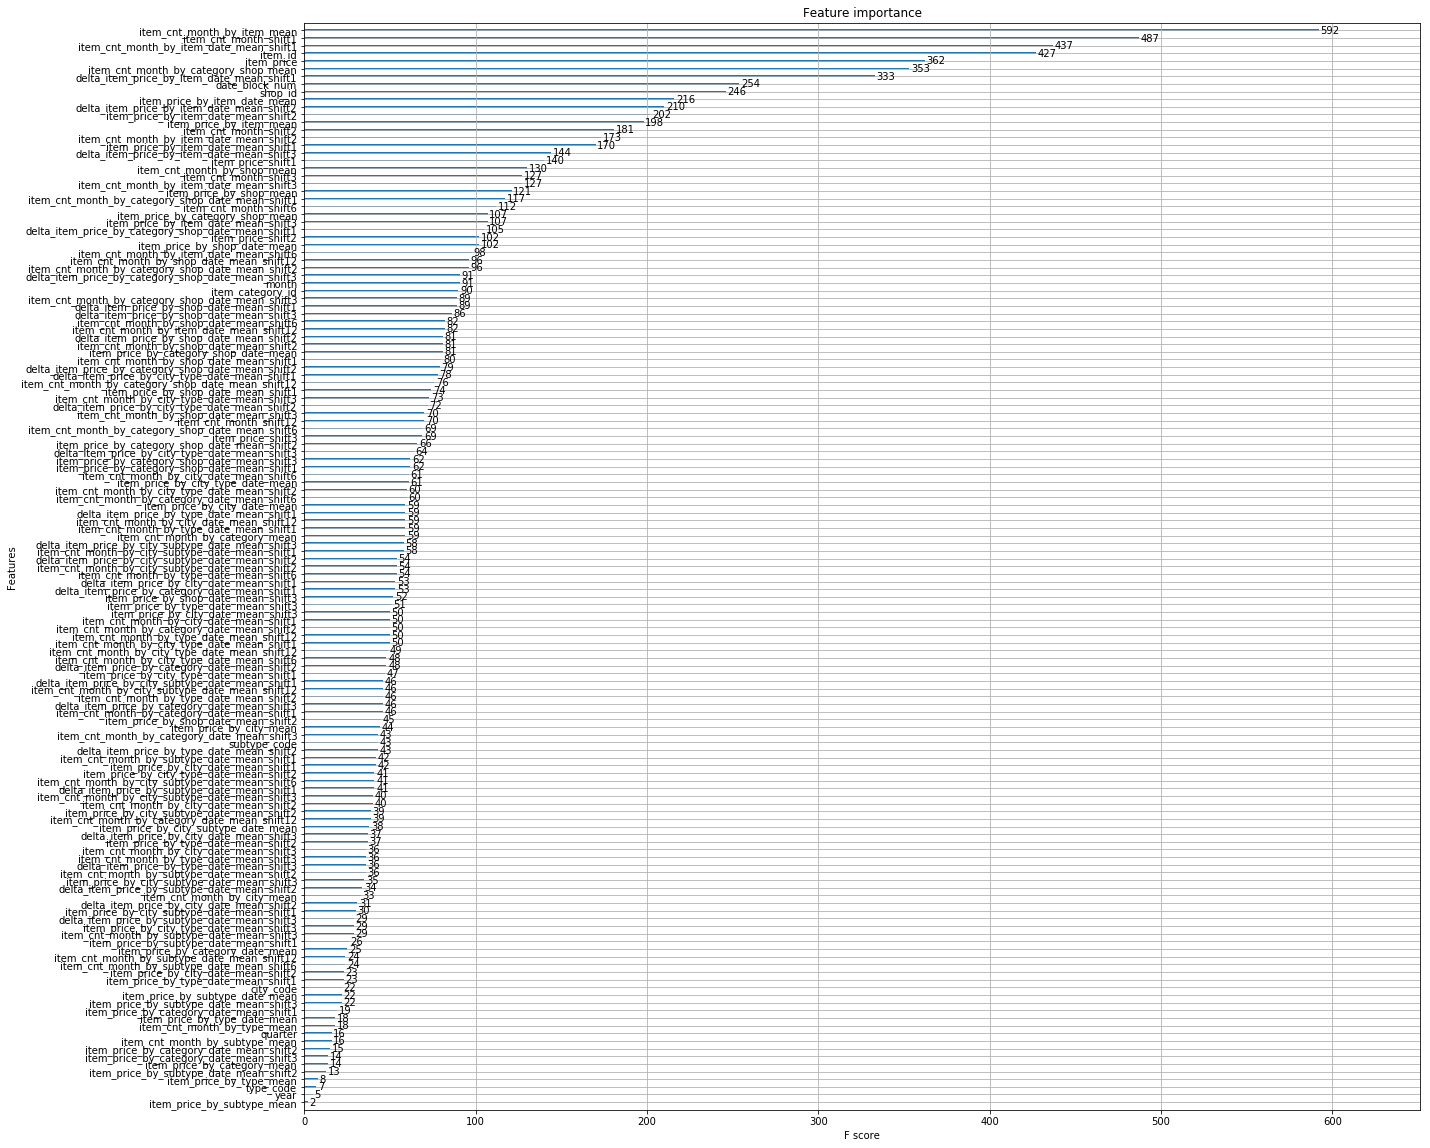

In [77]:
# plot the feature importances
fig, axes = plt.subplots(figsize=(20 , 20))
xgb.plot_importance(model_xgbreg, ax=axes)

> **Supply or submit the results**

Our submission to the competition site Kaggle is ready. Any suggestions to improve our score are welcome.

In [78]:
# feature extraction: fix the duplicated shop id
df_test.loc[df_test['shop_id'] == 0, 'shop_id'] = 57
df_test.loc[df_test['shop_id'] == 1, 'shop_id'] = 58
df_test.loc[df_test['shop_id'] == 11, 'shop_id'] = 10

In [79]:
# model selection
final_model = model_xgbreg

# prepare testing data and compute the observed value
x_test = df_block[df_block['date_block_num'] == 34].drop(['item_cnt_month'], axis=1)
y_test = pd.DataFrame({'item_cnt_month': final_model.predict(x_test).clip(0 ,20), 'shop_id': x_test['shop_id'], 'item_id': x_test['item_id']}, index=x_test.index)
y_test = pd.merge(y_test, df_test[['ID', 'shop_id', 'item_id']], how='left', on=['shop_id', 'item_id'])

In [80]:
# summit the results
out = pd.DataFrame({'ID': y_test['ID'], 'item_cnt_month': y_test['item_cnt_month']})
out.to_csv('submission.csv', index=False)